# Quiz 9

0.031601608052780776 std of coefficients
0.031636036226291325 mean bse


np.float64(0.94888)

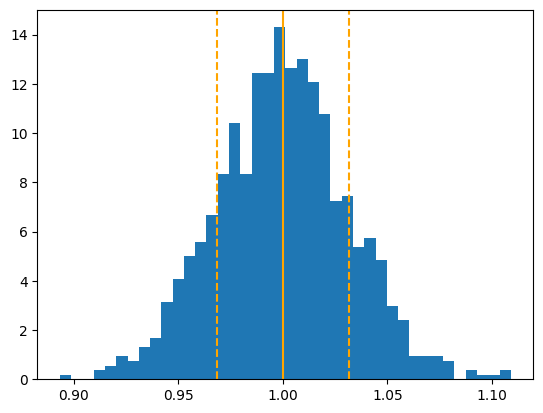

In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats

def compute_standard_error(true_effect, var_x, var_resid, sample_size, n_sims = 1000, random_seed = 0):
    np.random.seed(random_seed)

    params_list = list()
    bse_list = list()
    for _ in range(n_sims):
        x = np.random.normal(0, np.sqrt(var_x), sample_size)
        y = true_effect * x + np.random.normal(0, np.sqrt(var_resid), sample_size)
        df = sm.add_constant(pd.DataFrame({"X": x}))
        results = sm.OLS(y, df).fit()
        params_list.append(results.params.X)
        bse_list.append(results.bse.X)

    print(np.std(params_list), "std of coefficients")
    print(np.mean(bse_list), "mean bse")

    plt.hist(params_list, density = True, bins = 40)
    plt.axvline(true_effect, color = 'orange')
    plt.axvline(true_effect + np.std(params_list), color = 'orange', label = '+1 SE', linestyle = '--')
    plt.axvline(true_effect - np.std(params_list), color = 'orange', label = '-1 SE', linestyle = '--')

compute_standard_error(1, 1, 1, 1000, n_sims = 1000)

(np.random.normal(1.96 + 1.645, 1, 100000) > 1.96).mean()

In [2]:
# ------------------------------------------------------------
# Compute statistical power by simulating the t-test from OLS
# (two-sided test with critical |t| = 1.96)
# ------------------------------------------------------------
def compute_power(true_effect, sigma_x, sigma_resid, num, n_sim=10000, random_seed=0):
    np.random.seed(random_seed)
    critical_t = 1.96
    detections = 0

    for _ in range(n_sim):
        x = np.random.normal(0, sigma_x, size=num)
        y = 1 + true_effect * x + np.random.normal(0, sigma_resid, size=num)

        df = sm.add_constant(pd.DataFrame({"X": x}))
        results = sm.OLS(y, df).fit()

        t_value = results.tvalues.X
        if np.abs(t_value) >= critical_t:
            detections += 1

    power = detections / n_sim
    return power


power = compute_power(true_effect=(1.96 + 1.645) * np.sqrt(1 / 10),  sigma_x=1.0, sigma_resid=1.0, num=10,   n_sim=1000)
print(f"Estimated Statistical Power: {power:.4f}")
power = compute_power(true_effect=(1.96 + 1.645) * np.sqrt(1 / 1000), sigma_x=1.0, sigma_resid=1.0, num=1000, n_sim=1000)
print(f"Estimated Statistical Power: {power:.4f}")

Estimated Statistical Power: 0.8500
Estimated Statistical Power: 0.9460


In [3]:
# ------------------------------------------------------------
# Sample size sweep on a log grid (for a fixed effect, etc.)
# ------------------------------------------------------------
def sample_size_for_power(min_sample_size, max_sample_size, num_sizes):
    sizes_float = min_sample_size * np.exp(
        np.linspace(0, np.log(max_sample_size / min_sample_size), num=num_sizes)
    )
    sizes = [int(np.around(x)) for x in sizes_float]

    power_list = []
    for size in sizes:
        power = compute_power(0.5, 1, 1, size, 1000, 0)
        power_list.append(power)

    print(sizes)
    return power_list


sample_size_for_power(10, 1000, 10)

[10, 17, 28, 46, 77, 129, 215, 359, 599, 1000]


[0.341, 0.535, 0.714, 0.895, 0.995, 1.0, 1.0, 1.0, 1.0, 1.0]

In [4]:
def binary_search_for_sample_size(min_sample_size, max_sample_size, goal_power):
    average_sample_size = int((min_sample_size + max_sample_size) / 2)
    computed_power = compute_power(0.5, 1, 1, average_sample_size, 1000, 0)

    if min_sample_size == max_sample_size:
        return computed_power, average_sample_size

    if computed_power >= goal_power:
        return binary_search_for_sample_size(min_sample_size, average_sample_size, goal_power)

    return binary_search_for_sample_size(average_sample_size + 1, max_sample_size, goal_power)

binary_search_for_sample_size(10, 1000, 0.8)

(0.804, 34)

In [20]:
def simulate(A=1, B=1, C=10, D=1000):
  W = np.random.normal(0,1,D)
  X = W+np.random.normal(0,B,D)
  Y = A*X-W+np.random.normal(0,C,D)
  return Y, X, W

# Computer power of regression of Y~X controlling for W
def compute_power_regression(n_sim=10000,A=1, B=1, C=10, D=1000, random_seed=0):
    np.random.seed(random_seed)
    critical_t = 1.96
    detections = 0

    X_coeffs = []
    for _ in range(n_sim):
        Y, X, W = simulate(A=A, B=B, C=C, D=D)
        df = sm.add_constant(pd.DataFrame({"X": X, "W": W}))
        results = sm.OLS(Y, df).fit()
        X_coeffs.append(results.params.X)

        t_value = results.tvalues.X
        if np.abs(t_value) >= critical_t:
            detections += 1

    power = detections / n_sim
    skewness = stats.skew(X_coeffs)
    return power, skewness
for A in [0.5, 1, 2, 4]:
    power, skewness = compute_power_regression(n_sim=10000,A=A, B=1, C=10, D=100, random_seed=0)
    print(f"A={A}, power={power}, skewness={skewness}")
    

A=0.5, power=0.0779, skewness=0.00795260316093767
A=1, power=0.1735, skewness=0.007952603160937707
A=2, power=0.5032, skewness=0.00795260316093766
A=4, power=0.9713, skewness=0.0079526031609376
